<a href="https://colab.research.google.com/github/akhilvjose/Histopathological-Cancer-Detection/blob/master/NasNet_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akhilvjose","key":"71f5d23a7e193f84b6b261dca03a4434"}'}

In [0]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Jan  9 07:51 kaggle.json


In [0]:
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [1]:
!kaggle competitions list -s cancer

ref                                        deadline             category        reward  teamCount  userHasEntered  
-----------------------------------------  -------------------  ----------  ----------  ---------  --------------  
msk-redefining-cancer-treatment            2017-10-02 23:59:00  Research       $15,000       1386           False  
histopathologic-cancer-detection           2019-03-30 23:59:00  Playground   Knowledge        357            True  
intel-mobileodt-cervical-cancer-screening  2017-06-21 23:59:00  Featured      $100,000        848           False  
data-science-bowl-2017                     2017-04-12 23:59:00  Featured    $1,000,000       1972           False  
cervical-cancer-screening                  2016-02-01 23:59:00  Featured      $100,000         40           False  


In [0]:
!kaggle competitions download -c histopathologic-cancer-detection

  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 43.7MB/s]
  0% 0.00/5.10M [00:00<?, ?B/s]
100% 5.10M/5.10M [00:00<00:00, 47.0MB/s]
 99% 1.30G/1.30G [00:12<00:00, 123MB/s]
100% 1.30G/1.30G [00:12<00:00, 109MB/s]
100% 4.97G/4.98G [00:45<00:00, 138MB/s]
100% 4.98G/4.98G [00:45<00:00, 118MB/s]


In [0]:
!ls

kaggle.json  sample_submission.csv.zip	train_labels.csv.zip
sample_data  test.zip			train.zip


In [0]:
import zipfile
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
  zip_ref.extractall('train')
!rm train.zip
with zipfile.ZipFile('test.zip', 'r') as zip_ref:
  zip_ref.extractall('test')
!rm test.zip
with zipfile.ZipFile('train_labels.csv.zip', 'r') as zip_ref:
  zip_ref.extractall('train_labels.csv')
!rm train_labels.csv.zip
!ls -al

total 21912
drwxr-xr-x 1 root root     4096 Jan  9 07:56 .
drwxr-xr-x 1 root root     4096 Jan  9 07:12 ..
drwxr-xr-x 4 root root     4096 Jan  3 17:15 .config
-rw-r--r-- 1 root root       66 Jan  9 07:51 kaggle.json
drwxr-xr-x 1 root root     4096 Jan  3 17:15 sample_data
-rw-r--r-- 1 root root  1394488 Jan  9 07:51 sample_submission.csv.zip
drwxr-xr-x 2 root root  4300800 Jan  9 07:56 test
drwxr-xr-x 2 root root 16711680 Jan  9 07:56 train
drwxr-xr-x 2 root root     4096 Jan  9 07:56 train_labels.csv


In [4]:
import os
print(os.listdir())

['.config', 'kaggle.json', 'sample_submission.csv.zip', 'test', 'train_labels.csv', 'train', 'sample_data']


In [5]:
!ls train_labels.csv/train_labels.csv

train_labels.csv/train_labels.csv


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout, Dense, MaxPooling2D, BatchNormalization, Activation,Flatten,GlobalMaxPooling2D, Concatenate
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
#from keras.applications.resnet50 import ResNet50
#from keras.applications.resnet50 import preprocess_input
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import preprocess_input

from keras.applications.nasnet import NASNetMobile, NASNetLarge, preprocess_input

In [0]:
# import csv
# with open('train_labels.csv', 'rb') as csvfile:
#   train_df = csv.reader(csvfile)

In [8]:
train_df = pd.read_csv("train_labels.csv/train_labels.csv") # Since we unziped the file to train_labels.csv,it will be a directory
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [0]:
train_path = 'train'
test_path = 'test'

In [10]:
train_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

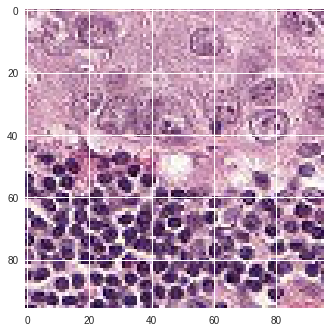

In [15]:
from glob import glob
image_files = glob(train_path + '/*.tif')

import matplotlib.pyplot as plt
from keras.preprocessing import image
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [0]:
# #VGG16 Code Implementation
# inp = Input((96,96,3)) 

# conv1  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(inp)
# conv2  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv1)
# pool1  = MaxPooling2D((2, 2))(conv2)

# conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
# conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
# pool2  = MaxPooling2D((2, 2))(conv4)

# conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
# conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
# conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
# pool3  = MaxPooling2D((2, 2))(conv7)

# conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
# conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
# conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
# pool4  = MaxPooling2D((2, 2))(conv10)

# # conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
# # conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
# # conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
# # pool5  = MaxPooling2D((2, 2))(conv13)

# #flat   = Flatten()(pool5)
# flat = GlobalAveragePooling2D()(pool4)
# #dense1 = Dense(1000, activation="relu")(flat)
# #Drop = Dropout(0.5)(dense1)
# #output = Dense(1000, activation="softmax")(dense2)

# #output = Dense(1, activation="sigmoid")(Drop)
# output = Dense(1, activation="sigmoid")(flat)
# model  = Model(inputs=inp, outputs=output)
# model.summary()

In [17]:
inp = Input((96, 96, 3))
NasM = NASNetMobile(include_top=False, input_shape=(96, 96, 3))#, weights=None
x = NasM(inp)
out1 = GlobalMaxPooling2D()(x)
out2 = GlobalAveragePooling2D()(x)
out3 = Flatten()(x)
out = Concatenate(axis=-1)([out1, out2, out3])
out = Dropout(0.5)(out)
out = Dense(1, activation="sigmoid", name="3_")(out)
model = Model(inp, out)

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
NASNet (Model)                  (None, 3, 3, 1056)   4269716     input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 1056)         0           NASNet[1][0]                     
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1056)         0           NASNet[1][0]                     
__________________________________________________________________________________________________
flatten_1 

In [0]:
datagen = ImageDataGenerator(rotation_range=0,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1, 
                             horizontal_flip=True, 
                             vertical_flip=True,
                             preprocessing_function=preprocess_input, 
                             data_format=None, 
                             validation_split=0.2)

In [19]:
#flow_from_dataframe(dataframe, directory, x_col='filename', y_col='class', target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, subset=None)
train_generator = datagen.flow_from_dataframe(dataframe = train_df,
                                              directory = 'train',
                                              x_col='id', 
                                              y_col='label', 
                                              target_size=(96, 96), 
                                              color_mode='rgb',
                                              has_ext=False,
                                              classes=None, 
                                              class_mode='binary', 
                                              batch_size=32, 
                                              shuffle=True,
                                              subset='training')

Found 176020 images belonging to 2 classes.


In [20]:
valid_generator = datagen.flow_from_dataframe(dataframe = train_df,
                                              directory = 'train',
                                              x_col='id', 
                                              y_col='label', 
                                              target_size=(96, 96), 
                                              color_mode='rgb',
                                              has_ext=False,
                                              classes=None, 
                                              class_mode='binary', 
                                              batch_size=32, 
                                              shuffle=True,
                                              subset='validation')

Found 44005 images belonging to 2 classes.


In [30]:
print(valid_generator.class_indices)

{0: 0, 1: 1}


In [0]:
model.compile(loss = 'binary_crossentropy',
             metrics = ['accuracy'],
             optimizer = Adam(0.0005))

In [31]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

r = model.fit_generator(train_generator,
                   validation_data = valid_generator,
                   epochs = 5,
                   steps_per_epoch = train_generator.n//32,
                   validation_steps = valid_generator.n // 32,
                   callbacks=[checkpoint])


Epoch 1/5
5500/5500 [==============================] - 3785s 688ms/step - loss: 0.3106 - acc: 0.8849 - val_loss: 1.5798 - val_acc: 0.6861

Epoch 00001: val_acc improved from -inf to 0.68607, saving model to model.h5
Epoch 2/5
5500/5500 [==============================] - 3731s 678ms/step - loss: 0.2305 - acc: 0.9141 - val_loss: 6.9752 - val_acc: 0.5170

Epoch 00002: val_acc did not improve from 0.68607
Epoch 3/5
5500/5500 [==============================] - 3923s 713ms/step - loss: 0.2029 - acc: 0.9238 - val_loss: 0.7226 - val_acc: 0.8597

Epoch 00003: val_acc improved from 0.68607 to 0.85971, saving model to model.h5
Epoch 4/5
5500/5500 [==============================] - 3770s 685ms/step - loss: 0.1796 - acc: 0.9339 - val_loss: 0.3781 - val_acc: 0.8760

Epoch 00004: val_acc improved from 0.85971 to 0.87601, saving model to model.h5
Epoch 5/5
5500/5500 [==============================] - 3868s 703ms/step - loss: 0.1614 - acc: 0.9406 - val_loss: 0.6651 - val_acc: 0.7733

Epoch 00005: val_a

In [32]:
!ls

clouderizer			kaggle.json		   train_labels.csv
clouderizer_init.sh		model.h5		   updatestatus
clouderizer.jar			sample_data		   updatestatus.1
clouderizer.service		sample_submission.csv.zip  updatestatus.2
colab_init.sh			test			   updatestatus.3
install_clouderizer_service.sh	train			   updatestatus.4


In [0]:
from google.colab import files
files.download('model.h5')

In [37]:
from glob import glob
from skimage.io import imread

base_test_dir = 'test/'
test_files = glob(os.path.join(base_test_dir,'*.tif'))
submission = pd.DataFrame()
file_batch = 5000
max_idx = len(test_files)
for idx in range(0, max_idx, file_batch):
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[1].split(".")[0])
    test_df['image'] = test_df['path'].map(imread)
    K_test = np.stack(test_df["image"].values)
    K_test = (K_test - K_test.mean()) / K_test.std()
    predictions = model.predict(K_test)
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head()

Indexes: 0 - 5000
Indexes: 5000 - 10000
Indexes: 10000 - 15000
Indexes: 15000 - 20000
Indexes: 20000 - 25000
Indexes: 25000 - 30000
Indexes: 30000 - 35000
Indexes: 35000 - 40000
Indexes: 40000 - 45000
Indexes: 45000 - 50000
Indexes: 50000 - 55000
Indexes: 55000 - 60000


,id,label
0,ff4e82df62afc11db738b7787740b4d5556b8972,6.953843e-08
1,df005a5b3eee1b44e8874b6c8747c31666a00d89,1.063225e-05
2,350a1b8c3a7ce3714645bd62cfab1ee819e5e6bb,3.133241e-03
3,4be59590e375ca51366581304df160db5e20dab4,1.326305e-03
4,bb44cadcfeea10b3cfc9c15098758dd2c40a7b47,1.288078e-01


In [0]:
submission.to_csv("submission.csv", index = False, header = True)

In [39]:
!ls

clouderizer			model.h5		   updatestatus
clouderizer_init.sh		sample_data		   updatestatus.1
clouderizer.jar			sample_submission.csv.zip  updatestatus.2
clouderizer.service		submission.csv		   updatestatus.3
colab_init.sh			test			   updatestatus.4
install_clouderizer_service.sh	train
kaggle.json			train_labels.csv


In [0]:
files.download('submission.csv')